In [152]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
from pathlib import Path
import kagglehub
from functools import lru_cache
from typing import Sequence
import statistics as st

np.set_printoptions(suppress=True)

In [326]:
# import
path = Path(kagglehub.dataset_download("mczielinski/bitcoin-historical-data"))/"btcusd_1-min_data.csv"
raw_records = pd.read_csv(
    path,
    usecols=["Open","High","Low","Close","Volume"],
    #nrows=100_000
)
first_datetime = datetime.fromisoformat(pd.read_csv(path,nrows=1).loc[0,"datetime"])
print("Done")

Done


In [327]:
# assigning a new index to group later
datetime_index = pd.date_range(
    start=first_datetime,
    freq=timedelta(minutes=1),
    periods=raw_records.index[-1]+1
)
records = raw_records
records.index = datetime_index
records.index.name = "datetime"
records.rename(columns=lambda col: col.lower(), inplace=True)
records.head()

,open,high,low,close,volume
datetime,,,,,
2012-01-01 10:01:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:02:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:03:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:04:00+00:00,4.58,4.58,4.58,4.58,0.0
2012-01-01 10:05:00+00:00,4.58,4.58,4.58,4.58,0.0


In [328]:
# groping
records = records.groupby(records.index.date).agg({
    "open": lambda x: x.iat[0],
    "high": "max",
    "low": "min",
    "close": lambda x: x.iat[-1],
    "volume": "sum"
})
records.index = pd.DatetimeIndex(records.index)
records.tail()

,open,high,low,close,volume
2025-03-12,82941.0,84437.0,80607.0,83620.0,2469.218470
2025-03-13,83677.0,84287.0,79910.0,81079.0,1830.000892
2025-03-14,81084.0,85294.0,80801.0,83975.0,1986.995114
2025-03-15,83984.0,85059.0,82397.0,82961.0,1134.769801
2025-03-16,82921.0,83404.0,81983.0,82566.0,131.322533


---
**If you held bitcoin for up to 30 days where would your profit lie?**

In [338]:
# reruning the cell will clear all the cache!
@lru_cache
def profit_quantiles(MAX_SPAN_DAYS: int = 30, QUANTILES: Sequence[float|int] = (0.01,0.25,0.5,0.75,0.99)) -> pd.DataFrame:
    return_of_hold = pd.DataFrame({k:0.0 for k in QUANTILES},index=range(1,MAX_SPAN_DAYS+1))
    
    grouped = records["close"].reset_index(drop=True)
    
    for span in range(2,MAX_SPAN_DAYS+1):
        res = (grouped
               .rolling(window=span)
               .apply(lambda srs: (srs.iat[-1] / srs.iat[0] - 1) * 100)
               .quantile(QUANTILES)
              )
        return_of_hold.loc[span] = res
    return return_of_hold

In [339]:
# calculate the profit
MAX_SPAN_DAYS = 30
QUANTILES = (0.01,0.25,0.5,0.75,0.99)

return_of_hold = profit_quantiles(MAX_SPAN_DAYS=MAX_SPAN_DAYS, QUANTILES=QUANTILES)

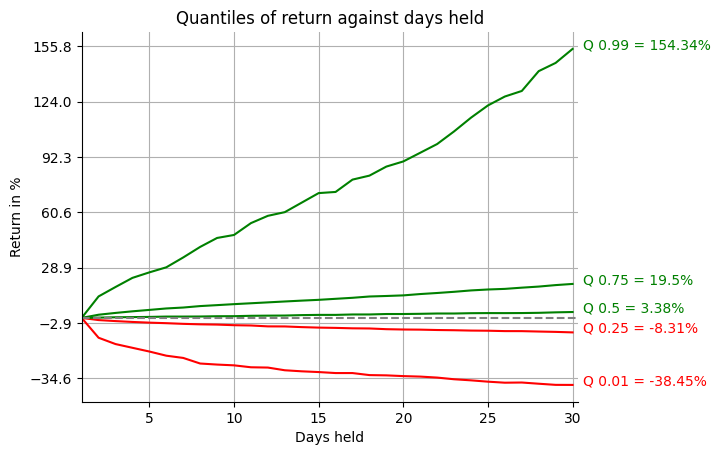

In [337]:
# charting
ax = plt.subplot()
for quantile, data in return_of_hold.items():
    if data.iat[-1] < 0:
        color = "red"
    elif data.iat[-1] == 0:
        color = "grey"
    else:
        color = "green"
        
    ax.plot(data,color=color)
    ax.text(x=MAX_SPAN_DAYS*1.02,y=data.iat[-1], s=f"Q {round(quantile,4)} = {round(data.iat[-1],2)}%", color=color)
    
ax.axhline(0,linestyle="dashed",color="grey")

ax.set_title("Quantiles of return against days held")
ax.grid()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_xlabel("Days held")
ax.set_xlim(1,MAX_SPAN_DAYS*1.01)

ax.set_yticks(
    np.arange(return_of_hold.min(axis=None)*0.9, return_of_hold.max(axis=None)*1.1, return_of_hold.mean(axis=None)*3).round(2)
)
ax.set_ylabel("Return in %");

---
**How does price change correlate with change of trading volume?**

In [388]:
QUANTILES = [0.05,0.95]

volume_change = records["volume"].pct_change().dropna()
price_change = records["close"] / records["open"] - 1

price_volume_change = pd.concat([volume_change,price_change],axis="columns")
price_volume_change.rename(columns={"volume":"volume_change", 0:"price_change"}, inplace=True)

mask = price_volume_change.isin([np.nan,np.inf,-np.inf])
price_volume_change[mask] = 0

volume_mask = pd.qcut(price_volume_change["volume_change"],q=QUANTILES).isna().to_numpy()
price_mask = pd.qcut(price_volume_change["price_change"],q=QUANTILES).isna().to_numpy()

general_mask = np.stack([volume_mask,price_mask],axis=1).any(axis=1)

indices_to_drop = price_volume_change.loc[general_mask].index
price_volume_change.drop(indices_to_drop,inplace=True)
price_volume_change.tail()

,volume_change,price_change
2025-03-11,-0.107875,0.054326
2025-03-12,-0.070522,0.008187
2025-03-13,-0.258874,-0.031048
2025-03-14,0.085789,0.035654
2025-03-15,-0.428902,-0.012181


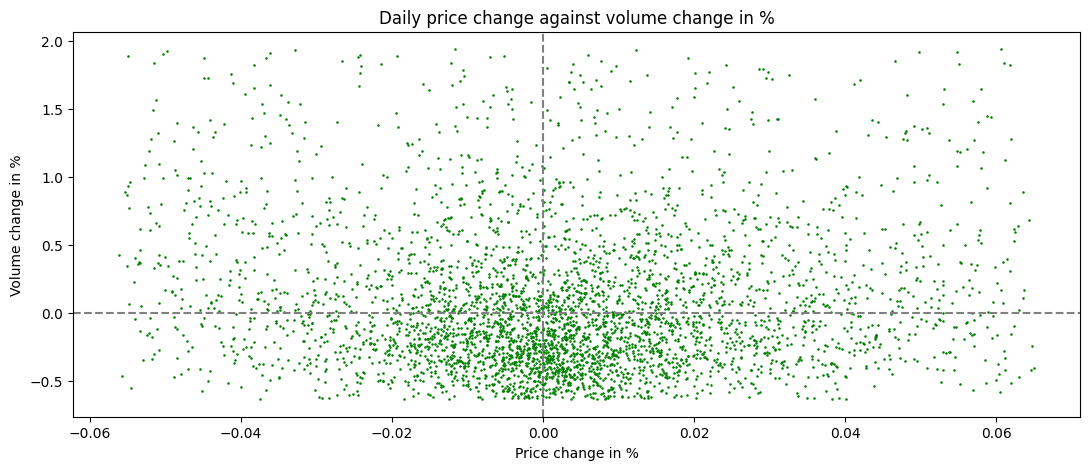

In [392]:
# charting
fig, ax = plt.subplots(figsize=(13,5))
ax.scatter(
    x=price_volume_change["price_change"],
    y=price_volume_change["volume_change"],
    s=0.7,
    color="green"
)

ax.axvline(x=0,linestyle="dashed",color="grey")
ax.axhline(y=0,linestyle="dashed",color="grey")

ax.set_ylabel("Volume change in %")
ax.set_xlabel("Price change in %")
ax.set_title("Daily price change against volume change in %");

---